In [359]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, average_precision_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [360]:
# load the dataset
df = pd.read_csv('/content/Depression Professional Dataset.csv')

In [361]:
df.head()

,Gender,Age,Work Pressure,Job Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work Hours,Financial Stress,Family History of Mental Illness,Depression
0,Female,37,2.0,4.0,7-8 hours,Moderate,No,6,2,No,No
1,Male,60,4.0,3.0,5-6 hours,Unhealthy,Yes,0,4,Yes,No
2,Female,42,2.0,3.0,5-6 hours,Moderate,No,0,2,No,No
3,Female,44,3.0,5.0,7-8 hours,Healthy,Yes,1,2,Yes,No
4,Male,48,4.0,3.0,7-8 hours,Moderate,Yes,6,5,Yes,No


In [362]:
print("Dataset Shape: ", df.shape)

Dataset Shape:  (2054, 11)


In [363]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2054 entries, 0 to 2053
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 2054 non-null   object 
 1   Age                                    2054 non-null   int64  
 2   Work Pressure                          2054 non-null   float64
 3   Job Satisfaction                       2054 non-null   float64
 4   Sleep Duration                         2054 non-null   object 
 5   Dietary Habits                         2054 non-null   object 
 6   Have you ever had suicidal thoughts ?  2054 non-null   object 
 7   Work Hours                             2054 non-null   int64  
 8   Financial Stress                       2054 non-null   int64  
 9   Family History of Mental Illness       2054 non-null   object 
 10  Depression                             2054 non-null   object 
dtypes: f

In [364]:
df.rename(
    columns={
        'Have you ever had suicidal thoughts ?' : 'Suicidal Thoughts',
        'Family History of Mental Illness' : 'Family Mental Health'
    }, inplace=True)

print(list(df.columns))

['Gender', 'Age', 'Work Pressure', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Suicidal Thoughts', 'Work Hours', 'Financial Stress', 'Family Mental Health', 'Depression']


# Handling Missing Data & Duplicates

In [365]:
# Check for missing values
missing_values = df.isnull().sum()

if missing_values.sum() > 0:
  print("Missing Values detected: ")
  print(missing_values[missing_values > 0])

  for col in df.columns:
    if df[col].isnull().sum() > 0:
      if df[col].dtype in ['int64','float64']:
        df[col].fillna(df[col].median(), inplace=True)
      else:
        df[col].fillna(df[col].mode(), inplace=True)
  print("Missing values have been handled.")
else:
  print("No Missing Values detected.")


No Missing Values detected.


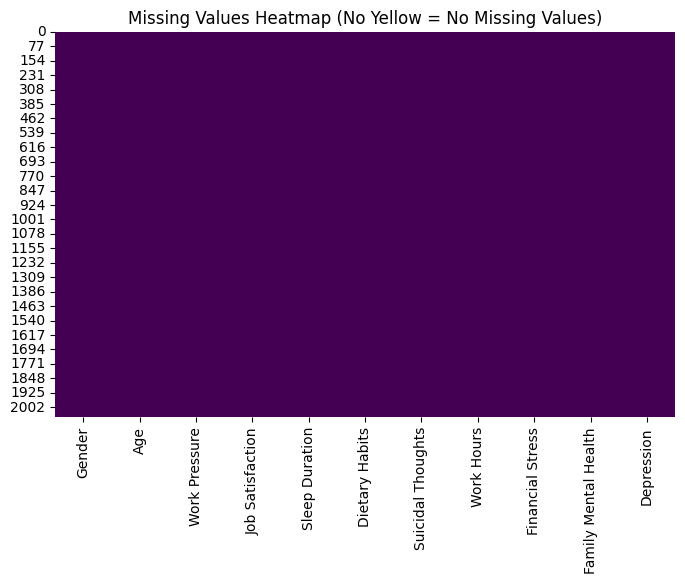

In [366]:
# Missing Values Heatmap
plt.figure(figsize=(8,5))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap (No Yellow = No Missing Values)")
plt.show()

In [367]:
# Check for duplicates
duplicates = df.duplicated().sum()

if duplicates > 0:
    print(f"Found {duplicates} duplicate rows.")
    df.drop_duplicates(inplace=True)
    print("Duplicates removed.")
else:
    print("No duplicate rows found in the dataset.")


No duplicate rows found in the dataset.


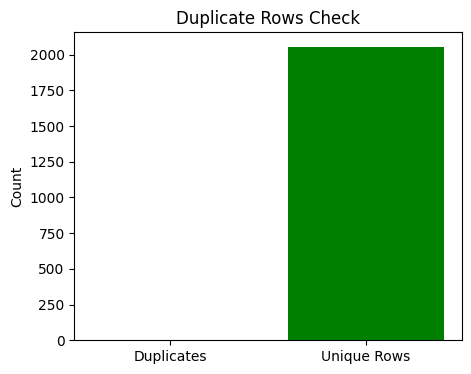

In [368]:
# Duplicates Bar Plot
plt.figure(figsize=(5,4))
duplicate_counts = [df.duplicated().sum(), len(df) - df.duplicated().sum()]
labels = ['Duplicates', 'Unique Rows']

plt.bar(labels, duplicate_counts, color=['red','green'])
plt.title("Duplicate Rows Check")
plt.ylabel("Count")
plt.show()

In [369]:
# Unique Values in each column except Age column
for col in df.columns:
  if col != "Age":
    print(col," :", df[col].unique())

Gender  : ['Female' 'Male']
Work Pressure  : [2. 4. 3. 1. 5.]
Job Satisfaction  : [4. 3. 5. 2. 1.]
Sleep Duration  : ['7-8 hours' '5-6 hours' 'More than 8 hours' 'Less than 5 hours']
Dietary Habits  : ['Moderate' 'Unhealthy' 'Healthy']
Suicidal Thoughts  : ['No' 'Yes']
Work Hours  : [ 6  0  1 12  3 11 10  8  7  9  5  2  4]
Financial Stress  : [2 4 5 3 1]
Family Mental Health  : ['No' 'Yes']
Depression  : ['No' 'Yes']


# Outlier Detection

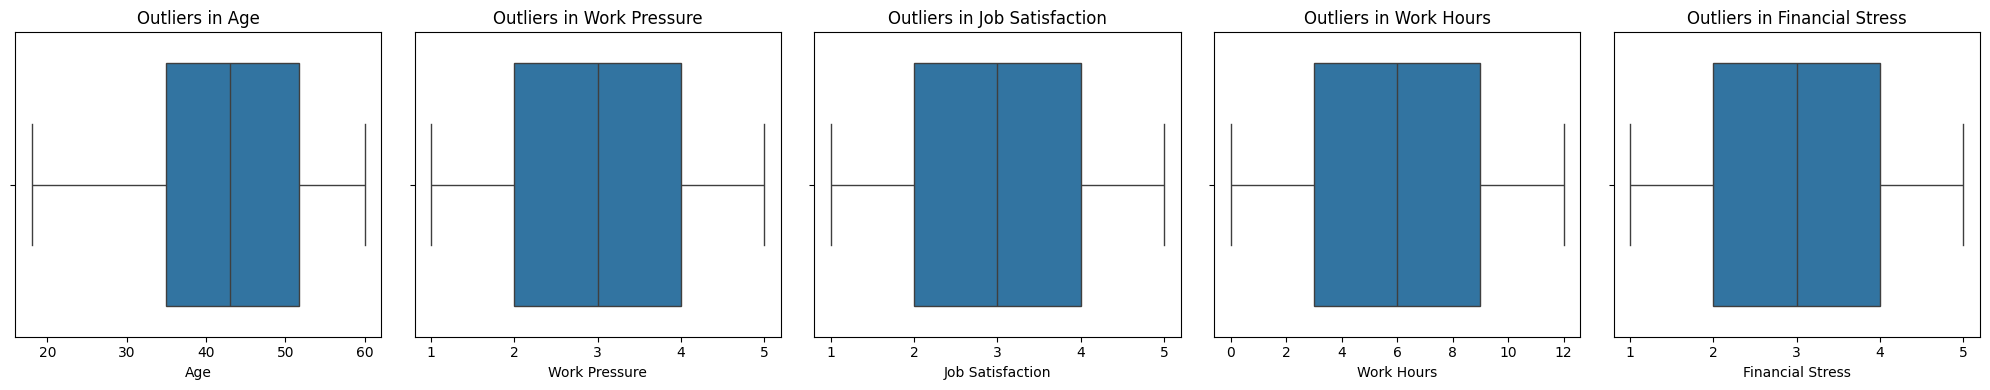

In [370]:
# Outlier Detection
# Boxplots
cols = ['Age', 'Work Pressure', 'Job Satisfaction', 'Work Hours', 'Financial Stress']

# Create box plots in 1 row with 5 columns
fig, axes = plt.subplots(1, len(cols), figsize=(20, 4))

for i, col in enumerate(cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Outliers in {col}")

plt.tight_layout()
plt.show()


In [371]:
# Function to detect outliers using IQR
def detect_outliers(col):
    Q1 = np.percentile(col, 25)
    Q3 = np.percentile(col, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((col < lower_bound) | (col > upper_bound)).sum()

# Check outliers in numerical columns
numerical_cols = ['Age', 'Work Pressure', 'Job Satisfaction', 'Work Hours', 'Financial Stress']
for col in numerical_cols:
    print(f"Outliers in {col}: {detect_outliers(df[col])}")

Outliers in Age: 0
Outliers in Work Pressure: 0
Outliers in Job Satisfaction: 0
Outliers in Work Hours: 0
Outliers in Financial Stress: 0


If Outliers were found, Below function can be used to filter values without having outliers



```
def remove_outliers_iqr(df, cols):
    df_clean = df.copy()
    for col in cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

numerical_cols = ['Age','Work Pressure','Job Satisfaction','Work Hours','Financial Stress']
df_no_outliers = remove_outliers_iqr(df, numerical_cols)
```



# Encoding Categorical Variables

In [372]:
# Label Encoding for Features with binary values
le_suicidal = LabelEncoder()
df['Suicidal Thoughts'] = le_suicidal.fit_transform(df['Suicidal Thoughts'])

le_gender = LabelEncoder()
df['Gender'] = le_gender.fit_transform(df['Gender'])

le_family = LabelEncoder()
df['Family Mental Health'] = le_family.fit_transform(df['Family Mental Health'])

le_depression = LabelEncoder()
df['Depression'] = le_depression.fit_transform(df['Depression'])

# Ordinal Encoding for Features with ordered values
sleep_order = [['7-8 hours', 'More than 8 hours', '5-6 hours', 'Less than 5 hours']]
ordinal_encoder_sleep = OrdinalEncoder(categories=sleep_order)
df['Sleep Duration'] = ordinal_encoder_sleep.fit_transform(df[['Sleep Duration']])

dietary_order = [['Healthy', 'Moderate', 'Unhealthy']]
ordinal_encoder_dietary = OrdinalEncoder(categories=dietary_order)
df['Dietary Habits'] = ordinal_encoder_dietary.fit_transform(df[['Dietary Habits']])

In [373]:
# Check class distribution
depression_counts = df['Depression'].value_counts()
print(depression_counts)

Depression
0    1851
1     203
Name: count, dtype: int64


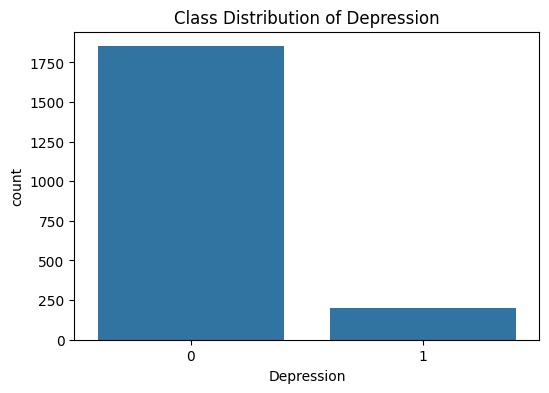

In [374]:
# Plot the distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Depression')
plt.title('Class Distribution of Depression')
plt.show()

In [375]:
X = df.drop('Depression', axis=1)
y = df['Depression']

# Splitting the dataset (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Feature Scaling

In [376]:
# Scaling the necessary features using StandardScaler
numerical_cols = ['Age', 'Work Hours', 'Work Pressure', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Financial Stress']
scaler = StandardScaler()
scaler.fit(X_train[numerical_cols])

X_train[numerical_cols]  = scaler.transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [377]:
# Define hyperparameters to tune for Logistic Regression
param_grid = {
    'C': [0.001, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

In [378]:
# Stratified K-Fold to maintain class balance in each fold
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [379]:
# Initialize Logistic Regression model
# class_weight='balanced' handles class imbalance
lr = LogisticRegression(class_weight='balanced',
                        solver='liblinear',
                        random_state=42,
                        max_iter=1000)

In [380]:
# GridSearchCV to find best hyperparameters using F1-score
grid = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=skf,
    scoring='f1',
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Best hyperparameters
print("Best parameters:", grid.best_params_)
print("Best CV f1:", grid.best_score_)


Best parameters: {'C': 100, 'penalty': 'l1'}
Best CV f1: 0.9469017367608916


In [381]:
# Retrieve the best model from GridSearch
best_model = grid.best_estimator_
# Train the best model on the training dataset
best_model.fit(X_train, y_train)

LogisticRegression(C=100, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')

In [382]:
# Perform cross-validation to evaluate model stability
cv_results = cross_validate(best_model,
                            X_train,
                            y_train,
                            cv=skf,
                            scoring=['f1', 'precision', 'recall']
)

# Calculate mean cross-validation scores
mean_f1 = cv_results['test_f1'].mean()
mean_precision = cv_results['test_precision'].mean()
mean_recall = cv_results['test_recall'].mean()

print(f"Mean CV F1-score: {mean_f1:.4f}")
print(f"Mean CV Precision: {mean_precision:.4f}")
print(f"Mean CV Recall: {mean_recall:.4f}")

Mean CV F1-score: 0.9469
Mean CV Precision: 0.9208
Mean CV Recall: 0.9756


In [383]:
# A higher threshold is chosen to prioritize recall and minimize false positives
optimal_threshold = 0.90

# Get predicted probabilities for the training set
y_train_prob = best_model.predict_proba(X_train)[:, 1]
# Apply threshold to convert probabilities into class labels
y_train_pred_final = (y_train_prob >= optimal_threshold).astype(int)

# Calculate training accuracy & ROC-AUC
train_acc = accuracy_score(y_train, y_train_pred_final)
train_auc = roc_auc_score(y_train, y_train_prob)

# Get predicted probabilities for the test set
y_prob = best_model.predict_proba(X_test)[:, 1]
# Apply threshold to convert probabilities into class labels
y_test_pred_final = (y_prob >= optimal_threshold).astype(int)

# Calculate testing accuracy & ROC-AUC
test_acc = accuracy_score(y_test, y_test_pred_final)
test_auc = roc_auc_score(y_test, y_prob)

# Display final model performance
print("\n===== Logistic Regression Model =====")
print(f"\nTraining Accuracy: {train_acc:.3f}")
print(f"Testing Accuracy:  {test_acc:.3f}")
print(f"\nTraining AUC:      {train_auc:.3f}")
print(f"Testing AUC:       {test_auc:.3f}")
print("\nClassification Report:")
print("\n",classification_report(y_test, y_test_pred_final))


===== Logistic Regression Model =====

Training Accuracy: 0.995
Testing Accuracy:  0.990

Training AUC:      1.000
Testing AUC:       1.000

Classification Report:

               precision    recall  f1-score   support

           0       1.00      0.99      0.99       370
           1       0.91      1.00      0.95        41

    accuracy                           0.99       411
   macro avg       0.96      0.99      0.97       411
weighted avg       0.99      0.99      0.99       411



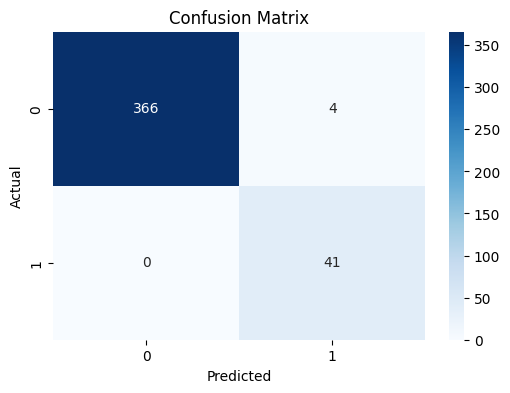

In [384]:
# Generate and visualize confusion matrix
cm = confusion_matrix(y_test, y_test_pred_final)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**This notebook was used to train and evaluate the Logistic Regression model.
The final trained model and preprocessing objects were exported using joblib and used in the FastAPI backend.**